# Solution of question number 2

In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

<b>Pricing of European put option using the implicit finite difference scheme

In [2]:
## Defining functions 'BSClosedForm' and 'printSurface' for analytical price calculation and printing the surface respectively.

def BSClosedForm(S0, K, r, T, sigma, is_call):
    # call or put
        d1 = ((r + 0.5 * sigma**2) * T + np.log(S0 /K )) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        p = 0.0
        
        if  is_call:
            p =  S0 * norm.cdf(d1) - np.exp(- r * T) *  K * norm.cdf(d2) 
        else:               
            p = np.exp(- r * T) *  K * norm.cdf(-d2) -  S0 * norm.cdf(-d1)
            
        return p

def printSurface(data, T, Smax, M, N):
    
        fig = plt.figure(figsize=(4,4))
        ax = Axes3D(fig)
        
        t, S = np.meshgrid(np.linspace(0, T, N+1), np.linspace(0, Smax, M+1))
        
        ax.plot_surface(t, S, data, cmap='coolwarm', linewidth=0, antialiased=False)
        ax.set_xlabel('time')
        ax.set_ylabel('stock price')
        ax.set_zlabel('option price')
        plt.show()

In [3]:
## Defining base class 'FiniteDifferences' which sets up the boundary conditions, sets up the coefficients, 
## does backward propagation and interpolation.        

class FiniteDifferences():

    def __init__(self, S0, K, r, T, sigma, Smax, M, N, is_call=True):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Smax = Smax
        self.M, self.N = int(M), int(N)  # Ensure M&N are integers
        self.is_call = is_call

        self.dS = Smax / float(self.M)
        self.dt = T / float(self.N)
        self.i_values = np.arange(self.M)
        self.j_values = np.arange(self.N)
        self.grid = np.zeros(shape=(self.M+1, self.N+1))
        self.boundary_conds = np.linspace(0, Smax, self.M+1)
        self.coeffs = None

    def _setup_boundary_conditions_(self):
        pass

    def _setup_coefficients_(self):
        pass

    def _traverse_grid_(self):
        """  Iterate the grid backwards in time """
        pass

    def _interpolate_(self):
        """Use piecewise linear interpolation on the initial grid column to get the closest price at S0."""
        return np.interp(self.S0, self.boundary_conds, self.grid[:, 0])

    def price(self):
        self._setup_boundary_conditions_()
        self._setup_coefficients_()
        self._traverse_grid_()
        return self._interpolate_()

In [4]:
## Defining child class 'FDExplicitEu' which inherits base class 'FiniteDifferences' 

class FDExplicitEu(FiniteDifferences):

    def _setup_boundary_conditions_(self):
        
        if self.is_call:
            self.grid[:, -1] = np.maximum(self.boundary_conds - self.K, 0)
            self.grid[-1, :-1] = self.Smax - self.K * \
                                 np.exp(-self.r *
                                        self.dt *
                                        (self.N-self.j_values))
        else:
            self.grid[:, -1] = \
                np.maximum(self.K-self.boundary_conds, 0)
            self.grid[0, :-1] = self.K * \
                                np.exp(-self.r *
                                      self.dt *
                                      (self.N-self.j_values))

    def _setup_coefficients_(self):
        
        self.a = 0.5*self.dt*((self.sigma**2) * (self.i_values**2) - self.r*self.i_values)
        self.b = 1 - self.dt*((self.sigma**2) * (self.i_values**2) + self.r)
        self.c = 0.5*self.dt*((self.sigma**2) * (self.i_values**2) + self.r*self.i_values)

    def _traverse_grid_(self):
        for j in reversed(self.j_values):
            for i in range(self.M)[1:]:
                self.grid[i,j] = self.a[i]*self.grid[i-1,j+1] +\
                                 self.b[i]*self.grid[i,j+1] + \
                                 self.c[i]*self.grid[i+1,j+1]


Analytical price is 2.89

Implicit FDS price is 2.89



C:\Users\ANIRBAN\AppData\Local\Temp/ipykernel_11440/721942655.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


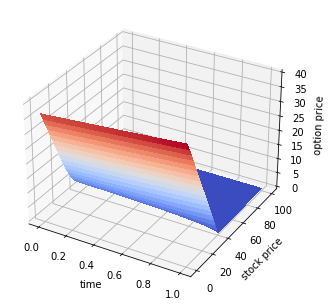

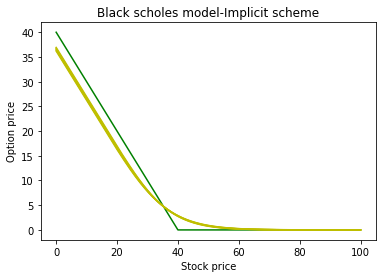

In [5]:
## Defining 'FDImplicitEu' class that inherits 'FDExplicitEu'

class FDImplicitEu(FDExplicitEu):
    
    def _setup_coefficients_(self):
        
        self.a = 0.5*self.dt*(self.r*self.i_values -
                      (self.sigma**2)*(self.i_values**2))
        self.b = 1 + \
                     self.dt*((self.sigma**2)*(self.i_values**2) + \
                              self.r)
        self.c = -0.5*self.dt*(self.r *self.i_values +
                       (self.sigma**2)*(self.i_values**2))
        
        self.coeffs = np.diag(self.a[2:self.M], -1) + \
                      np.diag(self.b[1:self.M]) + \
                      np.diag(self.c[1:self.M-1], 1)

    def _traverse_grid_(self):
        """ Solve using linear systems of equations """
        P, L, U = linalg.lu(self.coeffs)
        aux = np.zeros(self.M-1)

        for j in reversed(range(self.N)):
            aux[0] = np.dot(-self.a[1], self.grid[0, j])
            aux[-1] = np.dot(-self.c[-1], self.grid[-1, j])
            
            x1 = linalg.solve(L, self.grid[1:self.M, j+1]+aux)
            x2 = linalg.solve(U, x1)
            self.grid[1:self.M, j] = x2
            
    # Printing Analytical price alongside Implicit FDS price to check accuracy of Implicit FDS price.         
            
if __name__ == "__main__":
    
    price = BSClosedForm(40, 40, 0.1, 1.0, 0.3, False)
    print('\nAnalytical price is %.2f\n' %(price))
    
    option = FDImplicitEu(40, 40, 0.1, 1.0, 0.3, 100, 400, 400, False)
    
    print('Implicit FDS price is %.2f\n' %(option.price()))    
    
    printSurface(option.grid, 1.0, 100, 400, 400)
    
    #print along the stock price dimension of grid.

    s = np.linspace(0, 100, 401)
    plt.plot(s, option.grid[:,-1], 'g')
    
    for i in range(0, 100, 20):
        plt.plot(s, option.grid[:, i], 'y')
        
    plt.title('Black scholes model-Implicit scheme')
    plt.xlabel('Stock price')
    plt.ylabel('Option price')
    plt.show

<b> Comment on the stability of Finite Difference Scheme(FDS) used and its convergence:
   



Here we have used implicit FDS which does not suffer from stability issue unlike explicit FDS. Convergence rate of implicit FDS is linear which is same as that of explicit FDS. Implicit FDS is same as explicit FDS in terms of convergence.
    In our case, with M=400 and N=400, it is exactly converging to the analytical price and there is no stability issue.

<b>Pricing of down-and-out put option using the implicit finite difference scheme 

In [6]:
class FDImplicitDo(FDImplicitEu):

    def __init__(self, S0, K, r, T, sigma, Sbarrier, Smax, M, N, is_call=True):
        super(FDImplicitEu, self).__init__(S0, K, r, T, sigma, Smax, M, N, is_call)
        
        self.dS = (Smax-Sbarrier)/float(self.M)
        self.barrier = Sbarrier
        self.boundary_conds = np.linspace(Sbarrier, Smax, self.M+1)
        self.i_values = self.boundary_conds/self.dS
        
    def _setup_boundary_conditions_(self):
        self.grid[:, -1] = \
        np.maximum(self.K-self.boundary_conds, 0)
        self.grid[0, :] = 0.0
        
if __name__ == "__main__":
    option = FDImplicitDo(40, 40, 0.1, 1.0, 0.3, 30, 100, 400, 400, False)
    print ('\nPrice of this down-and-out put option is %0.2f' %option.price())


Price of this down-and-out put option is 0.59
